# Metrics

In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using Discretizers
using Base.Test

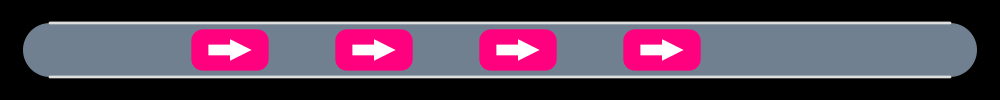

In [2]:
const Vehicle1D = Entity{PosSpeed1D, BoundingBoxDef, Int}
const Scene1D = Frame{Vehicle1D}
const Roadway1D = Wraparound{Straight1DRoadway}

def = BoundingBoxDef(AgentClass.CAR, 4.0, 2.0)
roadway = Wraparound(Straight1DRoadway(50.0))
scene = Frame([
    Vehicle1D(PosSpeed1D(10.0,10.0), def, 1),
    Vehicle1D(PosSpeed1D(18.0,12.0), def, 2),
    Vehicle1D(PosSpeed1D(26.0,10.0), def, 3),
    Vehicle1D(PosSpeed1D(34.0, 8.0), def, 4),
])
render(scene, Straight1DRoadway(50.0), cam=StaticCamera(VecE2(25.0,0.0), 18.0), canvas_height=100)

We create some features. Each feature must implement:
* f(scene, vehicle_indices, roadway) and produce a FeatureValue
* assign_metric(f, scene, roadway) and produce a Vector{Assignment} that point to vehicle indices

In [3]:
v(scene::Scene1D, vehicle_indices::Assignment, roadway::Roadway1D) = FeatureValue(scene[vehicle_indices[1]].state.v)
function AutoScenes.assign_metric{F <: typeof(v)}(f::F, scene::Scene1D, roadway::Roadway1D)
    return Assignment[(i,) for i in 1: length(scene)]
end

assignments = assign_metric(v, scene, roadway)
@test assignments == Assignment[(1,), (2,), (3,), (4,)]
@test Float64[v(scene, a, roadway) for a in assignments] == [10.0, 12.0, 10.0, 8.0]

Test Passed


We can pull the counts over a ListRecord.

In [7]:
rec = ListRecord(NaN, PosSpeed1D, BoundingBoxDef, Int)
push!(rec, scene)
metric = KLDivMetric(v, LinearDiscretizer([-9.0,0.0,9.0,15.0]))
countsQ = get_counts(metric, rec, roadway, [assignments])
@test countsQ == [0,1,3]

Test Passed


In [14]:
@test kullbeck_leibler_divergence(countsQ, countsQ, metric.disc) == 0.0
@test kullbeck_leibler_divergence([1,1], [2,2], metric.disc) == 0.0
@test isapprox(kullbeck_leibler_divergence([1,1], [1,2], LinearDiscretizer([0.0,1.0,2.0])), 
               0.5*log(0.5/(1/3)) + 0.5*log(0.5/(2/3)), atol=1e-8)

Test Passed
